# Trajectory Predictor Training

This notebook is used for training new trajectory predictor models on sequence data extracted from videos.

In [2]:
import os
os.chdir('/app/Pogona_realtime/Arena')

In [3]:
import numpy as np
import pandas as pd
import imp
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from functools import partial

from Prediction import dataset
from Prediction import train_eval
from Prediction import predictor
from Prediction import visualize
from Prediction import dataset
from Prediction import kalman_predict
from Prediction import seq2seq_predict
from Prediction import calibration as calib
from Prediction import traj_models

In [5]:
imp.reload(dataset)
imp.reload(train_eval)
imp.reload(seq2seq_predict)
imp.reload(predictor)
imp.reload(visualize)
imp.reload(dataset)
imp.reload(kalman_predict)
imp.reload(traj_models)

<module 'Prediction.traj_models' from '/app/Pogona_realtime/Arena/Prediction/traj_models.py'>

## Load data

Loads the entire detections data into a dataframe, bounded by the avavliable memory on the machine.

The options are the different sources of data that could be loded: the detections data itself, the timestamps of the camera recordings and and the screen touchings. If 'touches' is true, then timestamps must be true as well. 

'dlc' is supposed to align some of the offline DLC analysis with the frames, but the data need to be produced, so it will probably won't work in the future.

In [4]:
all_df = dataset.collect_data(data_sources={'detections': True, 'timestamps': True, 'dlc': False, 'touches': True})


223 trials loaded


### Filter Data

Generate Kalman filtered detections for the bounding box corners

In [ ]:
for trial in tqdm(all_df.index.unique()):
    filtered = kalman_predict.filter_trial(all_df.loc[trial], cols=['x1', 'y1'])
    all_df.loc[trial, ['flt_x1', 'flt_y1']] = filtered

    filtered = kalman_predict.filter_trial(all_df.loc[trial], cols=['x2', 'y2'])
    all_df.loc[trial, ['flt_x2', 'flt_y2']] = filtered

## Train Seq2Seq Trajectory Predictor

### Model Parameters


In [5]:
# Column labels used for input features and output ground truth.
input_labels = ['x1', 'y1', 'x2', 'y2']
output_labels = ['x1', 'y1', 'x2', 'y2']

# Network model parameters. See seq2seq_predict.py for more information.
net_params = {
    'decoder_type':"RNN",  # "RNN" or "Linear"
    'rnn_type': "GRU",  # "GRU" or "LSTM"
    'use_abs_pos': False,
    'tie_enc_dec': False,
    'use_rnn_cell': True,
    'input_labels': input_labels,
    'output_labels': output_labels,
    'input_dim': len(input_labels),
    'output_dim': len(output_labels),
    'inp_seq_len': 20,
    'out_seq_len': 10,
    'hidden_size': 350,
    'rnn_layers': 1,
    'dropout': 0.05,
}

### Choose masking parameters
The masking is used to train and evaluate on only a subset of the sequences data. The mask could be manually defined in the cell below, by setting the lower and upper bound on various statistics computed on the each sequence.

In [6]:
INF_P = 9999999

mask_dict = {
    'fl_dist': [0, INF_P, True, True],
    'speed': [12, INF_P, True, True],
    'std': [0, INF_P, [0,1]],
    'corr': [0.0, 1.0, True, True],
    'zgzg': [0, 1.0, True, True],
    'keep_prob': 0.0
}

mask_fn = train_eval.compose_masks(mask_fns=[
    train_eval.mask_fl_dist(*mask_dict['fl_dist']),
    train_eval.mask_speed(*mask_dict['speed']),
    train_eval.mask_std(*mask_dict['std']),
    train_eval.mask_corr(*mask_dict['corr']),
    train_eval.mask_zgzg(*mask_dict['zgzg'])
    ])

### Generate training samples
Generate the 3D sequence tensor data from the detections dataframe. The paramerters for the sequence length are determined by the models loaded earlier.

The sequences generated from each trial are first stored in a dictionary, that contains all of the sequences without masking, and the boolean mask for the trial itself. That way, the masked data can be acssessed on the fly, and updating the masking parameters does not require to compute the sequences again, only the mask. 

In [7]:
# only necessary once
trials_dict = train_eval.create_samples(df=all_df, 
                                        mask_fn=mask_fn,
                                        keep_prob=mask_dict['keep_prob'],
                                        input_labels=net_params['input_labels'], output_labels=net_params['output_labels'], 
                                        input_seq_size=net_params['inp_seq_len'], output_seq_size=net_params['out_seq_len'])

In [16]:
# run this cell only when masking is updated
train_eval.update_trials_dict(trials_dict, mask_fn, keep_prob=mask_dict['keep_prob'])

### Select a train / validation / test split

The sequences data is split according to individual trials. The train-validation-test split can be loaded from file, or re-computed. The split aims that each of the parts of the split has relatively equal proportion of sequences that pass the boolean mask. It is done by computing the ratio between the number of sequences that passed the mask, and the total number of sequences in that trial, sorting the trials according to these ratios, spliting the trials into batches, and selecting trials from each batch into the training, validation and test sets according to the split ratio.

In [8]:
# generate a new train/val/test trials split
train_trials, val_trials, test_trials = train_eval.split_train_val_test(trials_dict, split=(0.7, 0.15, 0.15))

In [13]:
# use a trials split from a previous training session
model_name = "RNN_GRU_1022-1159_i20_o20_h350_l1"
train_trials, val_trials, test_trials = traj_models.get_trials_split(model_name)

### Training Parameters

In [9]:
# Training parameters dictionary. See train_eval.py for more information.
training_params = {
    'batch_size': 256,
    'clip_grad_norm': 1.5,
    'lr': 0.00005,
    'loss_fn': 'ADE',
    'train_trials': train_trials,
    'val_trials': val_trials,
    'test_trials': test_trials,
    'sched_exp': 0
}

if training_params['loss_fn'] == "weighted ADE":
    # Parameters for exponentialy weighted loss
    # Weights the displacement at the end of the sequence higher than the beginning
    a = np.linspace(0.01, 0.2, num=net_params['out_seq_len'])[::-1]
    loss_weights = np.array([a[t] * np.prod(1-a[:t]) for t in range(len(a))])[::-1]
    training_params['loss_weights'] = loss_weights.tolist()
    loss_dict["weighted ADE"] = partial(train_eval.weighted_ADE, torch.from_numpy(loss_weights.copy()).to('cuda'))


### Create DataLoaders

After generating the trials sequence dictionary and the trials split, the training, validation and test datasets can be generated. They are Pytorch DataLoaders, used for iterating over the datasets in batches. The entire 3D Pytorch tensors can be also accessed.

In [10]:
train_dl, val_dl, test_dl = train_eval.create_train_val_test_dataloaders(trials_dict, train_trials, val_trials, test_trials,
                                                                         train_mask=True, val_mask=True, test_mask=False,
                                                                         batch_size=training_params['batch_size'], shuffle=True)

print("Sample size:")
print(f"Training: {len(train_trials)} trials, {len(train_dl.dataset)} seqs")
if val_dl is not None:
    print(f"Validation: {len(val_trials)} trials, {len(val_dl.dataset)} seqs")
if test_dl is not None:
    print(f"Test: {len(test_trials)} trials, {len(test_dl.dataset)} seqs")

Sample size:
Training: 159 trials, 4971 seqs
Validation: 32 trials, 594 seqs
Test: 32 trials, 136944 seqs


### Train

Train model according to the chosen parameters. Models weight files are saved to a folder as defined in traj_models.WEIGHT_DIR, and training results and parameters are stored in the json file (traj_models.MODELS_JSON_PATH).

In [11]:
# TrainingResults objects for each training session are stored in this list
all_results = []

In [12]:
model, results, interrupted = traj_models.train_model(training_params, 
                                                      net_params, 
                                                      mask_dict,
                                                      train_dl, 
                                                      val_dl, 
                                                      num_epochs=200, 
                                                      eval_freq=5, 
                                                      log_freq=5, 
                                                      model_name_suffix="RealExtreme", 
                                                      save_each_eval_model=False)

all_results.append(results)

Training model RNN_GRU_1119-1004_i20_o10_h350_l1_RealExtreme:

CUDA error: out of memory


Traceback (most recent call last):
  File "/app/Pogona_realtime/Arena/Prediction/traj_models.py", line 189, in train_model
    results=results,
  File "/app/Pogona_realtime/Arena/Prediction/train_eval.py", line 483, in train_trajectory_model
    model.to(device)
  File "/home/user/miniconda/envs/py37/lib/python3.7/site-packages/torch/nn/modules/module.py", line 607, in to
    return self._apply(convert)
  File "/home/user/miniconda/envs/py37/lib/python3.7/site-packages/torch/nn/modules/module.py", line 354, in _apply
    module._apply(fn)
  File "/home/user/miniconda/envs/py37/lib/python3.7/site-packages/torch/nn/modules/rnn.py", line 154, in _apply
    ret = super(RNNBase, self)._apply(fn)
  File "/home/user/miniconda/envs/py37/lib/python3.7/site-packages/torch/nn/modules/module.py", line 376, in _apply
    param_applied = fn(param)
  File "/home/user/miniconda/envs/py37/lib/python3.7/site-packages/torch/nn/modules/module.py", line 605, in convert
    return t.to(device, dtype if t.is

### Display results

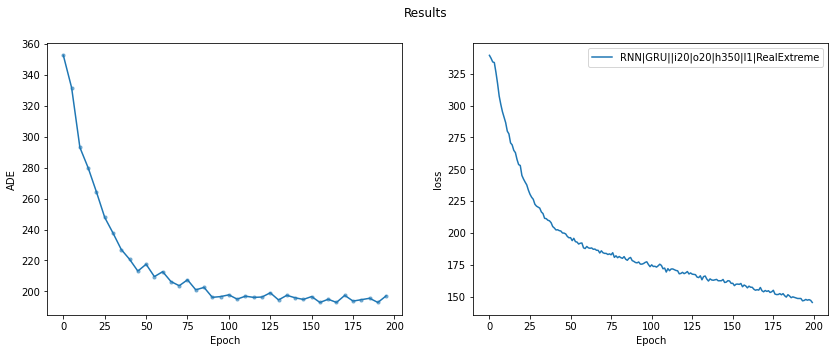

In [23]:
traj_models.plot_train_results(all_results, "Results", pretty=traj_models.pretty_name, fname="train_results")

## Kalman Parameter Search

Search for good variance parameters for the Q and R matrices using the Ax bayesian optimization library.

In [1]:
parameters=[
    {"name": "q_var", "type": "range", "bounds": [0.0, 100.0]},
    {"name": "r_var", "type": "range", "bounds": [0.0, 1000.0]},
]

In [2]:
num_derivs = 2

def eval_kalman_predictor(params):
    total_ADE = 0
    start_time = time()
    
    for trial in trial_names:        
        trial_bboxes = all_df.loc[trial][['x1', 'y1', 'x2', 'y2']].values        
        predictor = kalman_predict.KalmanPredictor(20, num_derivs, params["q_var"], params["r_var"])
        results, forecasts = train_eval.eval_trajectory_predictor(predictor, trial_bboxes, show_progress=False)
        total_ADE += results["avg ADE"]

        print(".", end="")
    mean_ADE = total_ADE / len(trial_names)
    print(f"params: {params} ADE:{mean_ADE} duration: {time() - start_time:.2f}")
    
    return mean_ADE

In [ ]:
best_parameters, values, experiment, model = optimize(
    parameters=parameters,
    evaluation_function=eval_kalman_predictor,
    objective_name='ADE',
    total_trials=100, 
    minimize=True)

### Best parameters for constant acceleration model

- {'q_var': 5.232464612645584, 'r_var': 76.11997188671926} ADE:77.80251293150333
- {'q_var': 8.305751509936852e-11, 'r_var': 6.104439686140315} ADE:56.59084980428664
- {'q_var': 11.243166495979125, 'r_var': 100.0} ADE:87.78338522412209
- {'q_var': 6.60728768670246, 'r_var': 68.14068332725518} ADE:84.5807759587622
- {'q_var': 3.179927344778319e-08, 'r_var': 99.99999991206423} ADE:47.3384215434221
- {'q_var': 1.0454159059256132, 'r_var': 250.94883769233357} ADE:49.15010262136672 (b
- {'q_var': 4.584311371533344, 'r_var': 99.99999999999997} ADE:70.82873570482703

### Best parameters for constant velocity model

- {'q_var': 5.370325791258682, 'r_var': 120.38665794106605} ADE:20.309112430927975
- {'q_var': 17.93990045743253, 'r_var': 134.50567199523354} ADE:22.291919662508487
- {'q_var': 31.548048307438687, 'r_var': 199.99999999999997} ADE:22.69878701033521
- {'q_var': 17.266130167990923, 'r_var': 162.3100133612752} ADE:21.791229502949385
- {'q_var': 2.1451830012770112, 'r_var': 119.49832681948244} ADE:19.396253677900415
- {'q_var': 10.68977698973989, 'r_var': 104.58652082983697} ADE:21.706828026167155
- {'q_var': 20.018173460688566, 'r_var': 180.35298309143698} ADE:21.881616195822115